# A Deep Q Neural Network tackles an inverted pendulum
![Moving around](https://www.cds.caltech.edu/~murray/wiki/images/c/c8/Anim_pend.gif)

For dynamical systems, stability is perhaps the most important thing we want to make sure. There are lots of different definitions of stability depending on different contexts. Roughly speaking, it means that the state of a dynamical system is always near some point (the equilibrium point). 

Let's take the inverted pendulum for an example - the controller you shall design has to make sure that the pendulum never falls down.

For this we use train a Deep Q Neural Network instead of doing the actual maths behind the problem (Lagrange's Equations). For more you information you can look [here](https://en.wikipedia.org/wiki/Inverted_pendulum).

#Coding
We start by importing the required dependencies.

In [0]:
import warnings
warnings.filterwarnings('ignore')

import gym
import random
import numpy as np
from collections import deque
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt

Next we set up the required environment for our model.

In [0]:
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# Seed
seed = 5
env.seed(seed)
random.seed(seed)
np.random.seed(seed)

Now we set our training parameters, which have been found through trial-and-error.

In [0]:
# Training parameterss
discount_factor = 0.99
epsilon_decay = 0.995
epsilon_min = 0.01
batch_size = 32
train_start = 1000
memory_size = 10000
n_episodes = 2000
n_win_ticks = 195
n_avg_scores = 100
render = False

Normally this following would be in a file for itself, but since this function does not work in google colab, we have pasted the code, that defvines our Mish(Activion) class.

In [0]:
# Import Necessary Modules.
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from keras.layers import Activation
from keras.utils.generic_utils import get_custom_objects
import keras.backend as K


class Mish(Activation):
  '''
  Mish Activation Function.

  .. math::

      mish(x) = x * tanh(softplus(x)) = x * tanh(ln(1 + e^{x}))

  Shape:
      - Input: Arbitrary. Use the keyword argument `input_shape`
      (tuple of integers, does not include the samples axis)
      when using this layer as the first layer in a model.

      - Output: Same shape as the input.

  Examples:
      >>> X = Activation('Mish', name="conv1_act")(X_input)
  '''

  def __init__(self, activation="Mish", **kwargs):
    super(Mish, self).__init__(activation, **kwargs)
    self.__name__ = 'Mish'


def mish(x):
  return x*K.tanh(K.softplus(x))


get_custom_objects().update({'Mish': Mish(mish)})

#Building the model

Now we are ready to actually build our model for the system

In [7]:
def build_model():
    model = Sequential()
    model.add(Dense(96, input_dim=state_size, kernel_initializer='he_uniform'))
    model.add(Mish())
    model.add(Dense(48, kernel_initializer='he_uniform'))
    model.add(Mish())
    model.add(Dense(24, kernel_initializer='he_uniform'))
    model.add(Mish())
    model.add(Dense(action_size, kernel_initializer='he_uniform'))
    model.compile(Adam(lr=0.001), loss='mse')
    return model

model = build_model()
target_model = build_model()

model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 96)                480       
_________________________________________________________________
mish_2 (Mish)                (None, 96)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 48)                4656      
_________________________________________________________________
mish_3 (Mish)                (None, 48)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 24)                1176      
_________________________________________________________________
mish_4 (Mish)                (None, 24)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)               

Now we define some training helpers.

In [0]:
# Training helpers
# Source: https://github.com/yanpanlau/CartPole/blob/master/DQN/CartPole_DQN.py
def update_target_model():
    target_model.set_weights(model.get_weights())

def get_action(state, epsilon):
    return np.random.randint(action_size) if np.random.rand() <= epsilon else np.argmax(model.predict(state)[0])

def train_replay():
    if len(memory) < train_start:
        return
    minibatch = random.sample(memory,  min(batch_size, len(memory)))
    state_t, action_t, reward_t, state_t1, terminal = zip(*minibatch)
    state_t = np.concatenate(state_t)
    state_t1 = np.concatenate(state_t1)
    targets = model.predict(state_t)
    Q_sa = target_model.predict(state_t1)
    targets[range(batch_size), action_t] = reward_t + discount_factor * np.max(Q_sa, axis=1) * np.invert(terminal)
    model.train_on_batch(state_t, targets)







[Episode 0] Average Score: 15.0


Solved after 3 tries! \o/
[Episode 100] Average Score: 211.44
[Episode 200] Average Score: 422.64
[Episode 300] Average Score: 398.58
[Episode 400] Average Score: 440.88
[Episode 500] Average Score: 331.09
[Episode 600] Average Score: 388.54
[Episode 700] Average Score: 454.31
[Episode 800] Average Score: 466.63
[Episode 900] Average Score: 492.39
[Episode 1000] Average Score: 453.72
[Episode 1100] Average Score: 467.53
[Episode 1200] Average Score: 366.75
[Episode 1300] Average Score: 454.98
[Episode 1400] Average Score: 383.16
[Episode 1500] Average Score: 426.7
[Episode 1600] Average Score: 413.15
[Episode 1700] Average Score: 460.67
[Episode 1800] Average Score: 367.68
[Episode 1900] Average Score: 474.59


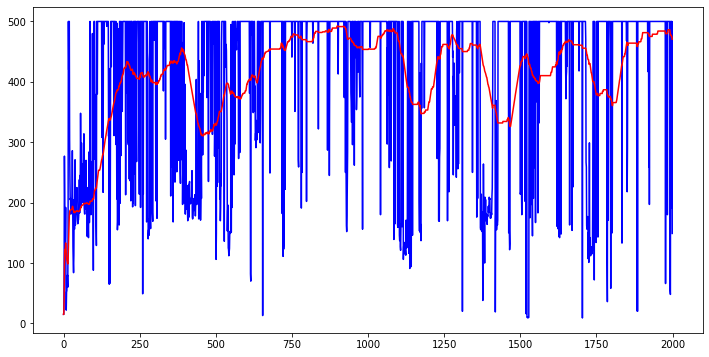

In [9]:
# Training
avg_scores = []
all_scores = []
scores = deque(maxlen=n_avg_scores)
memory = deque(maxlen=memory_size)

def learn_to_balance():
    epsilon = 1.0 # Start with randomness
    has_won = False

    for e in range(n_episodes):
        done = False
        score = 0
        state = env.reset()
        state = np.reshape(state, [1, state_size])

        while not done:
            action = get_action(state, epsilon)
            next_state, reward, done, info = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])

            memory.append((state, action, reward if not done else -100, next_state, done))
            if epsilon > epsilon_min:
                epsilon *= epsilon_decay # Decrease randomness
            train_replay()
            score += reward
            state = next_state
            
            if render:
                env.render()

            if done:
                env.reset()
                update_target_model()
                scores.append(score)
                all_scores.append(score)
                avg_score = np.mean(scores)
                avg_scores.append(avg_score)

                if not has_won and e >= n_avg_scores and avg_score >= n_win_ticks:
                    # Find first score greater than 195 where the average is >= 195 over the following 100 episodes.
                    solution_episode_idx = max(next(x[0] for x in enumerate(all_scores) if x[1] >= n_win_ticks), e - n_win_ticks) 
                    print('Solved after {} tries! \o/'.format(solution_episode_idx))
                    has_won = True

                if e % n_avg_scores == 0:
                    print('[Episode {}] Average Score: {}'.format(e, avg_score))

# Train model
# The challenge is solved at episode 3. The mean score remains >= 195 for the following 100 episodes.
# A higher score is very likely achievable through hyperparameter optimization and seed exploration.
# A better performance metric would span more episodes and cover a range of initial environment seeds.
learn_to_balance()

# Plot results
plt.figure(figsize=(12,6))
plt.plot(all_scores, color='blue')
plt.plot(avg_scores, color='red')
plt.show()